# Cooling Machine Optimization

`Prompt`: You are going to optimize the operation of a cooling machine. The engineering team tells you that it can be turned off when the external temperature is below 5 degrees but must be on otherwise. On top of this, the machine has to remain on for at least 2 hours when it is on, and off for at least 2 hours when it is off. The optimization step is one hour (i.e., every hour we have to send an on/off setpoint). Write a function that returns the setpoints that you would send to this cooling machine given the current status of the machine (is it on or off and for how long it has been this way), current external temperature and prediction of future external temperature and show how it works with an example. 

`Requirement`
- Machine turn-off ambient temperature set point: 5 deg. C.
- min. on/ff cycle:  2 hours
- optimization frequency: 1 hour
- command type: binary (on/off)

input: 
- external temperature
- machine feedback status (on/off)
- predicted of future external temperature

unknown variables:
- data logging frequency (assumed 1 min freq.)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import pandas as pd
from IPython.display import display, clear_output

## Generating Dummy Temperature Data with Predicted Future Temmperature

In [8]:
def generateTemps():
    mean_temp = 5
    st_dev = 1.5
    num_data = 24

    oa_t = np.random.normal(mean_temp,st_dev,num_data)
    daily_fluctuation = 10 * np.sin(np.arange(num_data) * (-2.25 *np.pi / num_data))
    oa_t += daily_fluctuation

    x = np.arange(len(oa_t))
    y = oa_t

    x= x[:,np.newaxis]
    y= y[:,np.newaxis]

    polynomial_features= PolynomialFeatures(degree=5)
    xp = polynomial_features.fit_transform(x)
    model = sm.OLS(y, xp).fit()
    oa_t_pred = model.predict(xp)

    return oa_t, oa_t_pred


curr_hour: 5
curr_temp: -5.642647849978239
future_temp: -4.224895975912952

opstat: 1
on_count: 6
off_count: 0
steady_state: True

sending machine status: 0


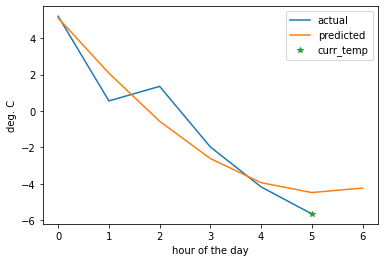

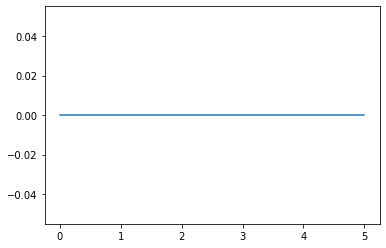

epoch: 6
##########################################################


In [23]:
# initiating optimization variables
steady_state = True
on_count = 0
off_count = 0
timer_th = 2 #hours
curr_hour = 24
oa_t, oa_t_pred = generateTemps()

def machine_command(curr_temp,future_temp):
    if curr_temp < 5:
        if steady_state == True:
            return 0
        else:
            return 1
    else:
        if steady_state == True:
            return 1
        else: 
            return 0
        
epoch = 0
machine_status = []

while True:
    opstat = int(input("enter machine status: "))
    clear_output(wait=True)  # Clear the previous output
    future_hour = curr_hour + 1

    if curr_hour > 23:
        curr_hour = curr_hour%24
    
    if future_hour > 23:
        future_hour = future_hour%24

    curr_temp = oa_t[curr_hour]
    future_temp = oa_t_pred[future_hour] 
    try:
        if opstat == 1:
            on_count += 1
            off_count = 0
        elif opstat == 0:
            off_count += 1
            on_count = 0
        else:
            print("invalid opstat input")
            break

        if off_count or on_count >= timer_th:
            steady_state = True
        else:
            steady_state = False

        machine_cmd = machine_command(curr_temp,future_temp)
        machine_status.append(machine_cmd)

        print("")
        print("curr_hour: " + str(curr_hour))
        print("curr_temp: " + str(curr_temp))
        print("future_temp: " + str(future_temp))
        print("")
        print("opstat: " + str(opstat))
        print("on_count: " + str(on_count))
        print("off_count: " + str(off_count))
        print("steady_state: " + str(steady_state))
        print("")
        print("sending machine status: " + str(machine_cmd))

        plt.plot(oa_t[:curr_hour+1], label="actual")
        plt.plot(oa_t_pred[:curr_hour+2], label="predicted")
        plt.plot(curr_hour,oa_t[curr_hour],"*",label="curr_temp") 
        plt.xlabel("hour of the day")
        plt.ylabel("deg. C")
        plt.legend()
        plt.show()

        plt.plot(machine_status)
        plt.show()

        if machine_command != None:
            epoch += 1
            curr_hour += 1
        
        print("epoch: " + str(epoch))
        print("##########################################################")

    except Exception as e:
        print(e)